In [29]:
#Import packages
import seaborn as sns
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#LDA Coherence scores
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

#NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# Data Splitting and Resampling
from sklearn.model_selection import train_test_split

# Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

# Reports
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Model
from sklearn import svm

In [30]:
filtered_df = pd.read_excel('april02.xlsx')

In [31]:
filtered_df.head()

,text,type
0,database project affect environment affect pro...,database
1,sql stick production seem like sql stuck produ...,database
2,database medium folder migration stage able re...,database
3,sql server go away error log addition previous...,database
4,location fail graph overall elastic monitor si...,database


In [32]:
#checking of null values
filtered_df['text'].isnull().sum()

1

In [33]:
filtered_df.dropna(subset=['text'], inplace=True)

In [34]:
text_data = filtered_df['text'].tolist()

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the text data to obtain TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(text_data)

# Extract feature names (words)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Calculate TF-IDF scores for each word
tfidf_scores = tfidf_matrix.sum(axis=0).A1

# Create a DataFrame to store words and their TF-IDF scores
tfidf_df = pd.DataFrame({'Word': feature_names, 'TF-IDF Score': tfidf_scores})

# Sort the DataFrame by TF-IDF scores in descending order
tfidf_df = tfidf_df.sort_values(by='TF-IDF Score', ascending=False)

# Get the top 1000 words based on TF-IDF scores
top_1000_words = tfidf_df.head(1000)

# Display the top 1000 words
print(top_1000_words)

             Word  TF-IDF Score
2102      elastic   1492.892949
1765       deploy   1399.141215
2439       fastly   1218.075715
7145       upsize    979.251997
2181  engineering    913.763567
...           ...           ...
1418      context     20.889653
2494        final     20.846125
4547    otherwise     20.714032
3810      locally     20.663966
3152        ideal     20.657046

[1000 rows x 2 columns]


In [35]:
#converting top_1000_words to list format
top_1000_words_list = top_1000_words['Word'].tolist()
print(top_1000_words_list)

['elastic', 'deploy', 'fastly', 'upsize', 'engineering', 'database', 'magento', 'production', 'upgrade', 'sql', 'version', 'cloud', 'error', 'disk', 'space', 'redis', 'environment', 'staging', 'search', 'information', 'change', 'increase', 'datum', 'fail', 'solution', 'tool', 'size', 'service', 'stage', 'await', 'infrastructure', 'sendgrid', 'cache', 'use', 'open', 'app', 'day', 'log', 'integration', 'response', 'add', 'we', 'file', 'server', 'notification', 'domain', 'time', 'specialist', 'check', 'review', 'product', 'storage', 'good', 'merchant', 'run', 'report', 'project', 'configuration', 'experience', 'build', 'available', 'affect', 'well', 'reopen', 'assist', 'share', 'create', 'new', 'late', 'mail', 'memory', 'root', 'get', 'site', 'set', 'solve', 'may', 'away', 'let', 'name', 'schedule', 'right', 'see', 'work', 'backup', 'account', 'user', 'type', 'complete', 'take', 'table', 'stick', 'maria', 'package', 'send', 'one', 'dump', 'would', 'technical', 'false', 'composer', 'confir

In [36]:
# Removing the remaining words which are not in to top_1000_words_list from the text column
filtered_df['tfidf_text'] = filtered_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word in (top_1000_words_list)]))


In [37]:
filtered_df['tfidf_text'].iloc[0]

'database project affect environment affect production staging environment name staging select leave empty change database backup merchant date end observe na change make change already do troubleshoot validate na production site live yes database datum consent grant make sure primary contact grant explicit permission client datum via panel well backup database last one one august database create directly one reopen right away may mail experience survey link commit good class experience would greatly appreciate we improve engineering database backup step reproduce database add infra wait keep post patel engineering database find database disk database requirement retrieve database redis southeast backup database vol snap complete vol retrieve database redis southeast backup database vol snap complete vol end retrieve database redis southeast backup database vol snap complete vol soon retrieval process complete good database database retrieve mount first elastic production elastic datab

In [38]:
filtered_df['text'].iloc[0]

'database project affect environment affect production staging environment name staging select leave empty change database backup merchant date end observe na change make change already do troubleshoot validate na production site live yes database datum consent grant make sure primary contact grant explicit permission client datum via panel well backup database last one one august maxim database create directly one reopen right away may mail experience survey link commit good class experience would greatly appreciate we improve engineering database backup step reproduce database balance add infra wait keep post patel engineering database find database disk database fit requirement retrieve database redis southeast backup database vol snap complete vol retrieve database redis southeast backup database vol snap complete vol end retrieve database redis southeast backup database vol snap complete vol soon retrieval process complete good database database retrieve mount first elastic produc

In [39]:
filtered_df.head()

,text,type,tfidf_text
0,database project affect environment affect pro...,database,database project affect environment affect pro...
1,sql stick production seem like sql stuck produ...,database,sql stick production seem like sql stuck produ...
2,database medium folder migration stage able re...,database,database medium folder migration stage able re...
3,sql server go away error log addition previous...,database,sql server go away error log previous message ...
4,location fail graph overall elastic monitor si...,database,location fail graph elastic monitor sincerely ...


In [41]:
######LDA model from gensim

# Set seeds for reproducibility
random.seed(35)
np.random.seed(35)

# Preprocess the text data
processed_docs = filtered_df['tfidf_text'].apply(lambda x: simple_preprocess(x))

# Create a CountVectorizer object
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(filtered_df['tfidf_text'])

# Create a Gensim Dictionary
id2word = Dictionary(processed_docs)

# Convert the text data to a Gensim corpus
corpus = [id2word.doc2bow(doc) for doc in processed_docs]

# Initialize variables
start_topics = 9
end_topics = 12
coherence_scores = []

# Iterate over different numbers of topics
for num_topics in range(start_topics, end_topics + 1):
    # Create LDA model using Gensim
    lda = LdaModel(corpus, id2word=id2word, num_topics=num_topics)

    # Get coherence score
    coherence_model = CoherenceModel(model=lda, texts=processed_docs, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)

# Print coherence scores for different numbers of topics
print("\nCoherence Scores:")
for num_topics, score in zip(range(start_topics, end_topics + 1), coherence_scores):
    print(f"Number of Topics: {num_topics}, Coherence Score: {score}")


Coherence Scores:
Number of Topics: 9, Coherence Score: 0.46968681222551584
Number of Topics: 10, Coherence Score: 0.4828999219179867
Number of Topics: 11, Coherence Score: 0.477243598008948
Number of Topics: 12, Coherence Score: 0.4447916263050562


In [22]:

# Set seeds for reproducibility
random.seed(24)
np.random.seed(24)

# Vectorize the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(filtered_df['tfidf_text'])

# Apply NMF to the TF-IDF matrix
num_topics = 10 # specify the number of topics/clusters
nmf_model = NMF(n_components=num_topics)
nmf_matrix = nmf_model.fit_transform(tfidf_matrix)

# Get the top words for each topic
feature_names = tfidf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(nmf_model.components_):
    print(f"Topic {topic_idx + 1}:")
    print([feature_names[i] for i in topic.argsort()[:-10 - 1:-1]])

Topic 1:
['deploy', 'fail', 'magento', 'error', 'stick', 'integration', 'cloud', 'composer', 'stuck', 'tool']
Topic 2:
['fastly', 'domain', 'cache', 'block', 'add', 'service', 'configuration', 'snippet', 'page', 'solution']
Topic 3:
['upsize', 'size', 'production', 'temporary', 'resize', 'false', 'infrastructure', 'change', 'schedule', 'date']
Topic 4:
['space', 'disk', 'increase', 'redis', 'storage', 'app', 'export', 'share', 'pub', 'medium']
Topic 5:
['elastic', 'search', 'open', 'number', 'analysis', 'curl', 'product', 'build', 'type', 'install']
Topic 6:
['database', 'backup', 'dump', 'production', 'snap', 'maria', 'table', 'vol', 'create', 'user']
Topic 7:
['sendgrid', 'domain', 'record', 'send', 'mail', 'add', 'net', 'account', 'verify', 'cloud']
Topic 8:
['upgrade', 'version', 'maria', 'service', 'production', 'staging', 'environment', 'change', 'infrastructure', 'schedule']
Topic 9:
['memory', 'cache', 'human', 'redis', 'key', 'magento', 'product', 'error', 'connection', 'peak'

In [23]:
# Get the indices of the dominant topics for each document
dominant_topics = nmf_matrix.argmax(axis=1)

# Add a new column 'topic' to the DataFrame and assign the dominant topic for each document
filtered_df['nmf_topic'] = dominant_topics

# Display the DataFrame with the assigned topics
filtered_df.head()


,Unnamed: 0,text,type,tfidf_text,nmf_topic
0,0,database project affect environment affect pro...,database,database project affect environment affect pro...,5
1,1,sql stick production seem like sql stuck produ...,database,sql stick production seem like sql stuck produ...,9
2,2,database medium folder migration stage able re...,database,database medium folder migration stage able re...,5
3,3,sql server go away error log addition previous...,database,sql server go away error log previous message ...,9
4,4,location fail graph overall elastic monitor si...,database,location fail graph elastic monitor sincerely ...,1


In [24]:
filtered_df['nmf_topic'].value_counts()

nmf_topic
0    3218
1    2294
2    2191
4    2138
8    1946
3    1939
5    1783
7    1398
9    1085
6     930
Name: count, dtype: int64

In [25]:
# Assign names to each topic
filtered_df.loc[filtered_df['nmf_topic'] == 0, 'nmf_topic'] = 'Deploy'
filtered_df.loc[filtered_df['nmf_topic'] == 1, 'nmf_topic'] = 'Fastly'
filtered_df.loc[filtered_df['nmf_topic'] == 2, 'nmf_topic'] = 'Upsize'
filtered_df.loc[filtered_df['nmf_topic'] == 3, 'nmf_topic'] = 'Resources'
filtered_df.loc[filtered_df['nmf_topic'] == 4, 'nmf_topic'] = 'Elasticsearch'
filtered_df.loc[filtered_df['nmf_topic'] == 5, 'nmf_topic'] = 'database'
filtered_df.loc[filtered_df['nmf_topic'] == 6, 'nmf_topic'] = 'Sendgrid'
filtered_df.loc[filtered_df['nmf_topic'] == 7, 'nmf_topic'] = 'Upgrade_services'
filtered_df.loc[filtered_df['nmf_topic'] == 8, 'nmf_topic'] = 'Redis'
filtered_df.loc[filtered_df['nmf_topic'] == 9, 'nmf_topic'] = 'Database_Admin'

In [26]:
filtered_df.head()

,Unnamed: 0,text,type,tfidf_text,nmf_topic
0,0,database project affect environment affect pro...,database,database project affect environment affect pro...,database
1,1,sql stick production seem like sql stuck produ...,database,sql stick production seem like sql stuck produ...,Database_Admin
2,2,database medium folder migration stage able re...,database,database medium folder migration stage able re...,database
3,3,sql server go away error log addition previous...,database,sql server go away error log previous message ...,Database_Admin
4,4,location fail graph overall elastic monitor si...,database,location fail graph elastic monitor sincerely ...,Fastly


In [27]:
filtered_df['nmf_topic'].value_counts()

nmf_topic
Deploy              3218
Fastly              2294
Upsize              2191
Elasticsearch       2138
Redis               1946
Resources           1939
database            1783
Upgrade_services    1398
Database_Admin      1085
Sendgrid             930
Name: count, dtype: int64

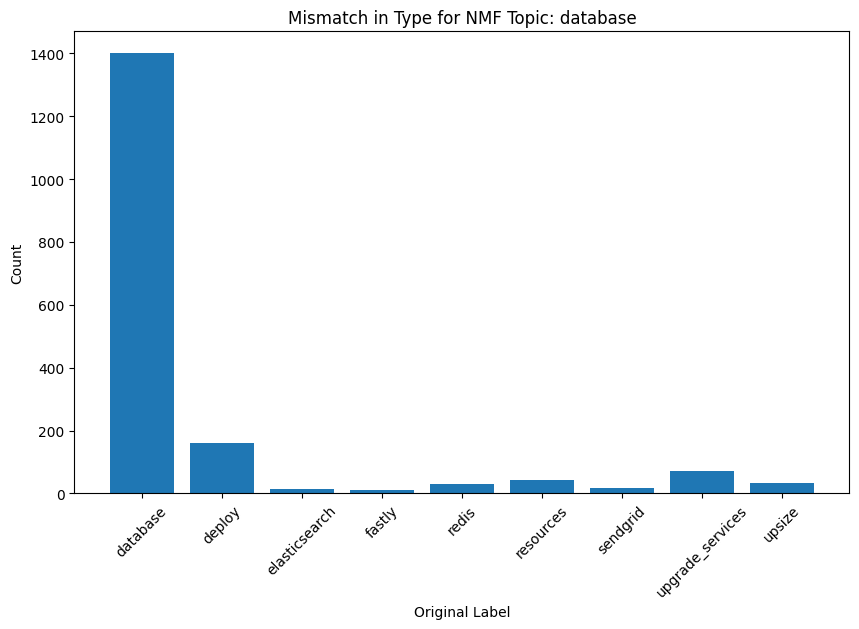

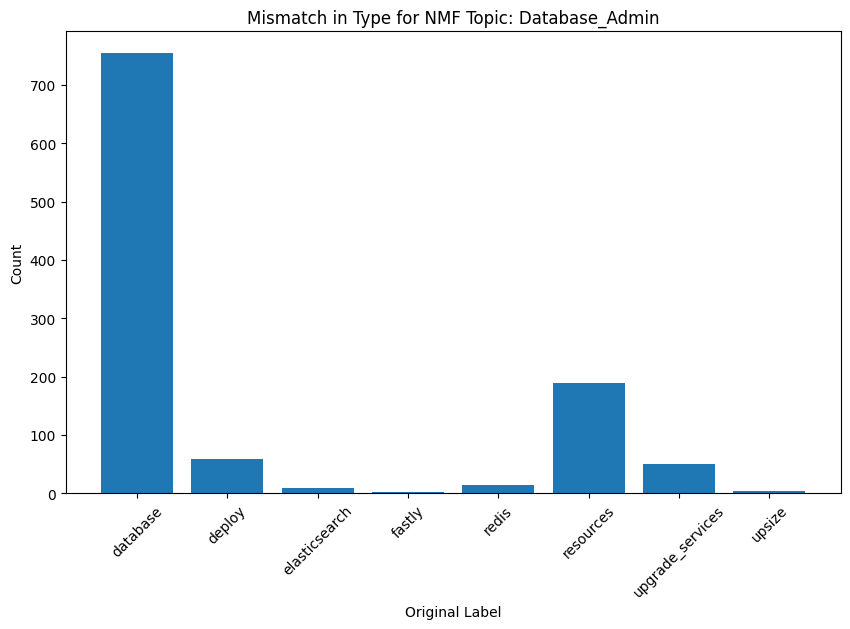

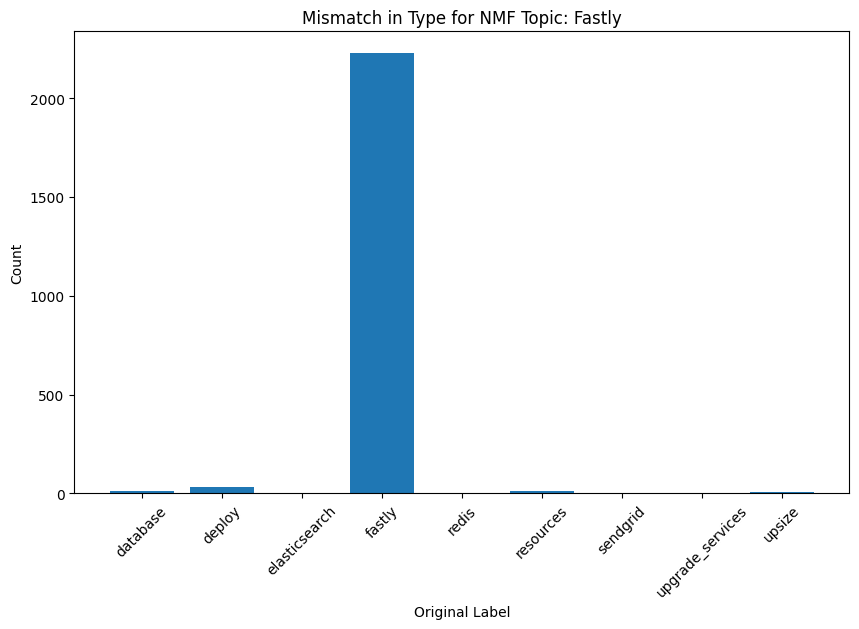

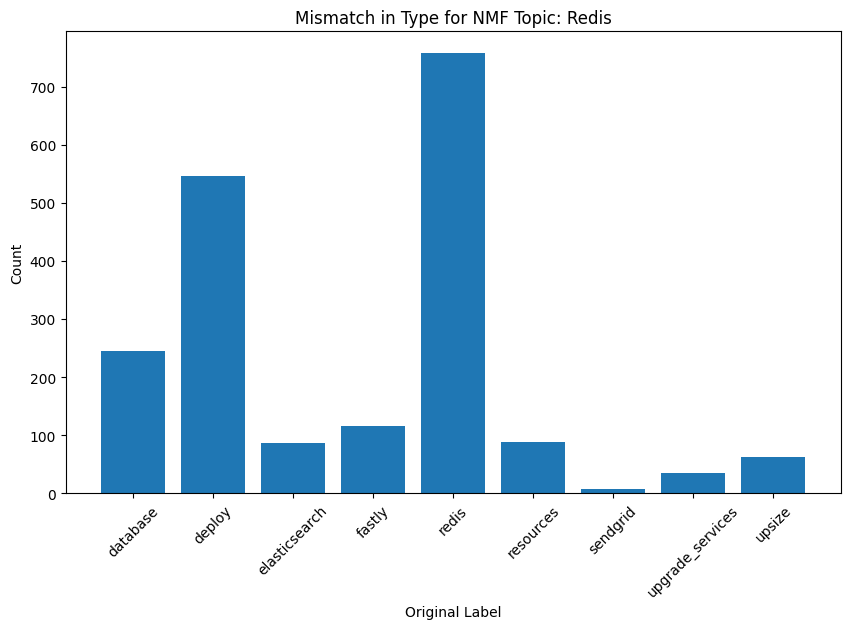

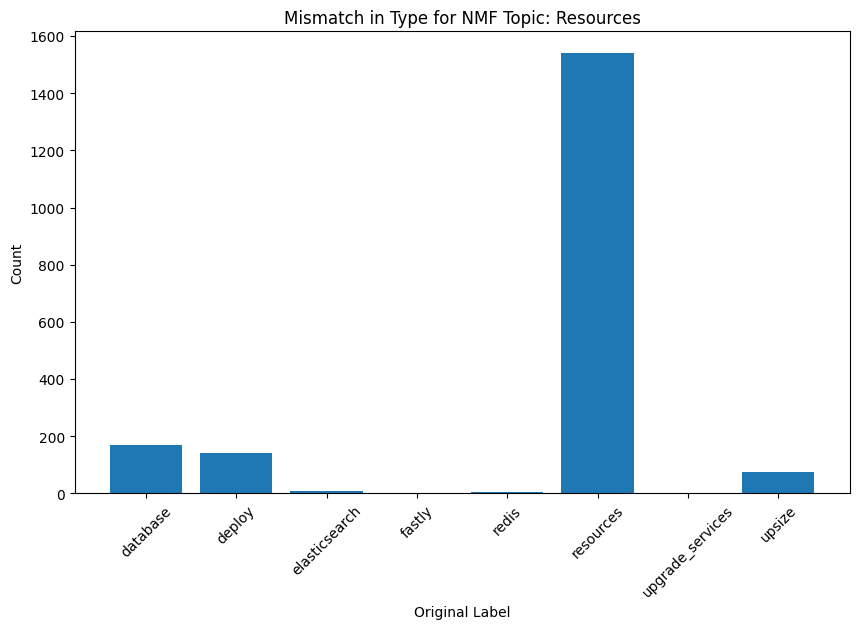

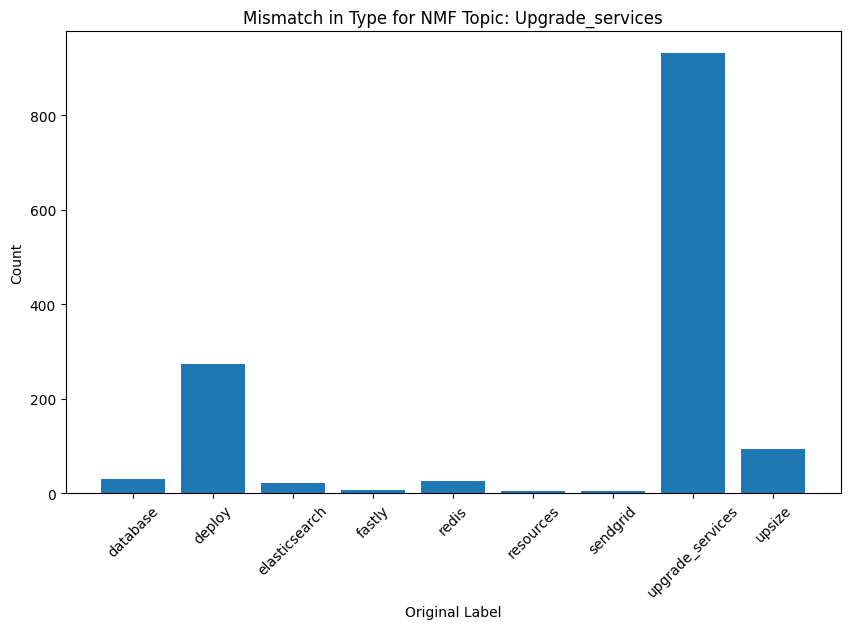

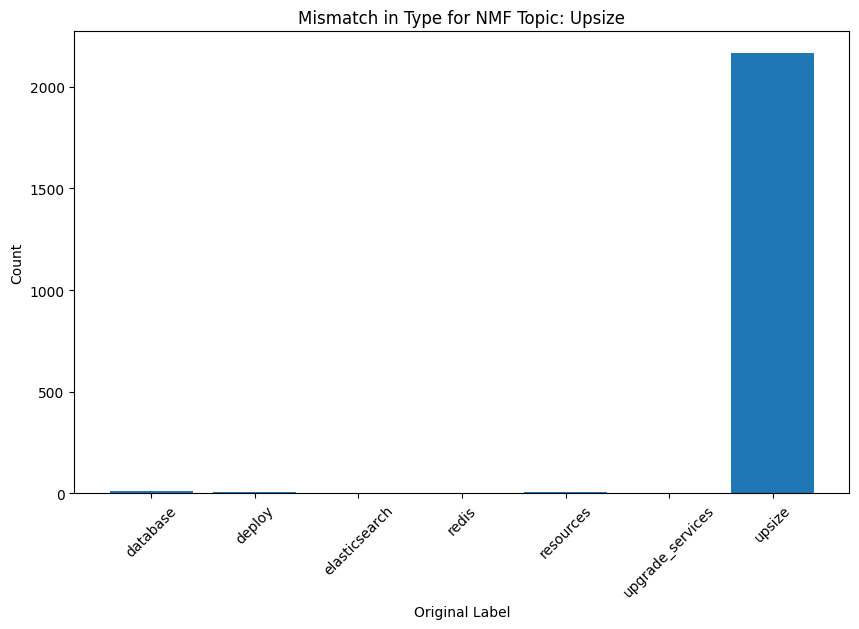

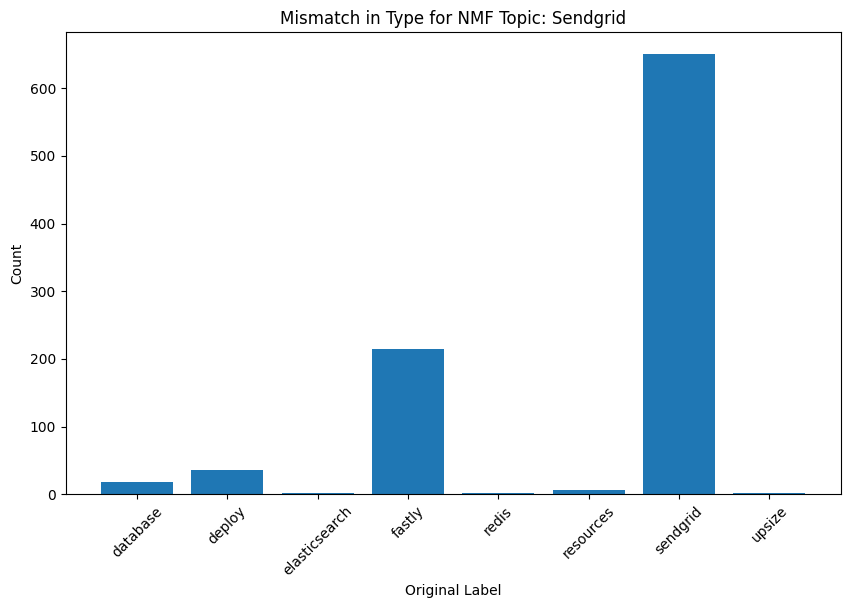

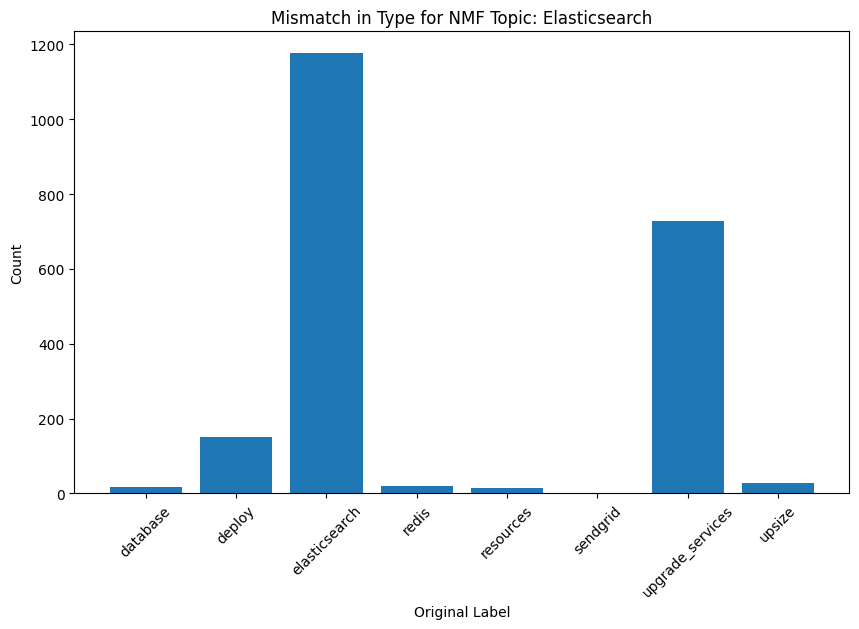

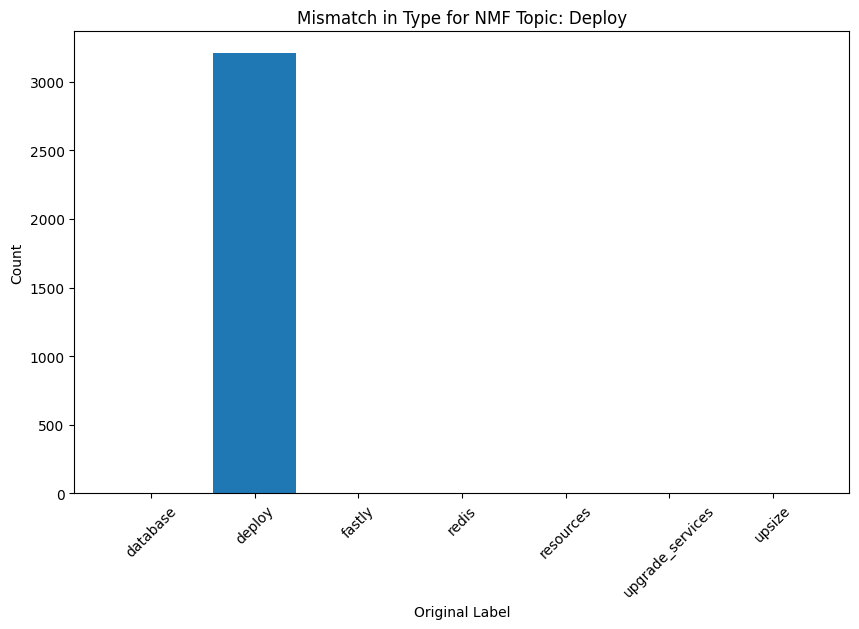

In [28]:
# Group the data by 'topic' and 'type' and count the occurrences
topic_type_counts = filtered_df.groupby(['nmf_topic', 'type']).size().reset_index(name='count')

# Create a bar chart for each topic
for topic in filtered_df['nmf_topic'].unique():
  # Filter the data for the current topic
  topic_data = topic_type_counts[topic_type_counts['nmf_topic'] == topic]
  plt.figure(figsize=(10,6))
  # Create a bar chart
  plt.bar(topic_data['type'], topic_data['count'])
  plt.xticks(rotation=45)
  # Set the x-axis label
  plt.xlabel('Original Label')

  # Set the y-axis label
  plt.ylabel('Count')

  # Set the title of the chart
  plt.title(f'Mismatch in Type for NMF Topic: {topic}')

  # Display the chart
  plt.show()

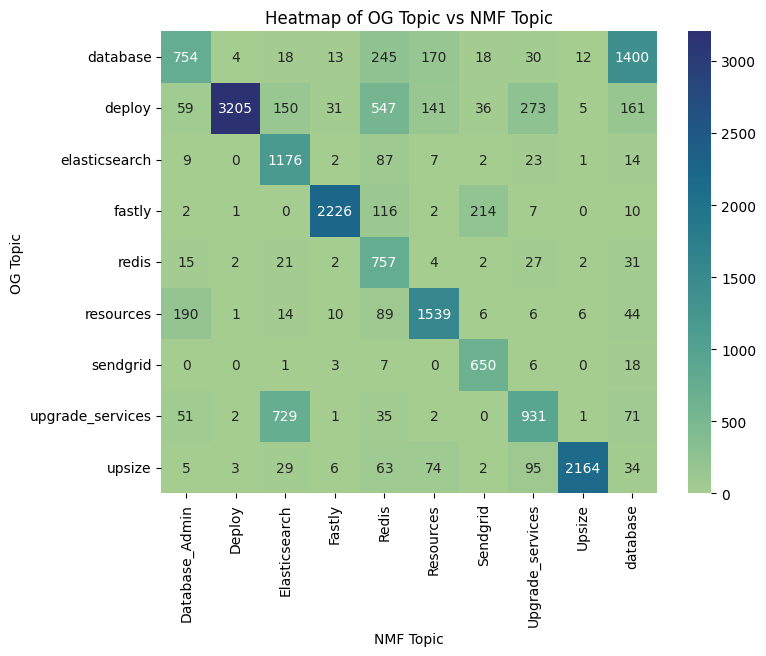

In [ ]:
filtered_df['type'] = pd.Categorical(filtered_df['type'])
filtered_df['nmf_topic'] = pd.Categorical(filtered_df['nmf_topic'])

# Create a cross-tabulation of the two variables
cross_tab = pd.crosstab(filtered_df['type'], filtered_df['nmf_topic'])

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cross_tab, annot=True, cmap='crest', fmt='d')
plt.title('Heatmap of OG Topic vs NMF Topic')
plt.xlabel('NMF Topic')
plt.ylabel('OG Topic')
plt.show()

In [ ]:
# Loading into a csv file
filtered_df.to_csv('nmf_categories_apr23.csv')

In [ ]:
df_nmf = pd.read_csv('nmf_categories_apr23.csv')

In [ ]:
df_nmf = df_nmf.rename(columns={'type':'og'})

In [ ]:
df_nmf.head()

,Unnamed: 0,text,og,tfidf_text,nmf_topic
0,0,database project affect environment affect pro...,database,database project affect environment affect pro...,database
1,1,sql stick production seem like sql stuck produ...,database,sql stick production seem like sql stuck produ...,Database_Admin
2,2,database medium folder migration stage able re...,database,database medium folder migration stage able re...,database
3,3,sql server go away error log addition previous...,database,sql server go away error log previous message ...,Database_Admin
4,4,location fail graph overall elastic monitor si...,database,location fail graph elastic monitor sincerely ...,Fastly


In [ ]:
# Rename categories
df_nmf['nmf_topic'] = df_nmf['nmf_topic'].str.lower()
df_nmf['nmf_topic'] = df_nmf['nmf_topic'].replace('upgrade', 'upgrade_services')
df_nmf['nmf_topic'] = df_nmf['nmf_topic'].replace('deployment_issues', 'deploy')
df_nmf['nmf_topic'] = df_nmf['nmf_topic'].replace('application_deployment_issues', 'app_deploy')
df_nmf['nmf_topic'] = df_nmf['nmf_topic'].replace('memory', 'redis')
# Recheck categories
print('nmf')
print(pd.unique(df_nmf['nmf_topic']))
print('og')
print(pd.unique(df_nmf['og']))

nmf
['database' 'database_admin' 'fastly' 'redis' 'resources'
 'upgrade_services' 'upsize' 'sendgrid' 'elasticsearch' 'deploy']
og
['database' 'upgrade_services' 'elasticsearch' 'sendgrid' 'redis' 'fastly'
 'resources' 'upsize' 'deploy']


In [ ]:
# Assign independent and dependent variables
x = df_nmf['tfidf_text']
y = df_nmf[['og','nmf_topic']]

# Split datasets into training and testing sets
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2, random_state = 0)

# Define vectorizer
vectorizer = TfidfVectorizer()

# Vectorize xtrain and xtest
vector_xtrain = vectorizer.fit_transform(xtrain)
vector_xtest = vectorizer.transform(xtest)

In [ ]:
# Produce a classification report
print(classification_report(y['og'], y['nmf_topic']))

/Users/anishachitturu/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                  precision    recall  f1-score   support

        database       0.79      0.53      0.63      2664
  database_admin       0.00      0.00      0.00         0
          deploy       1.00      0.70      0.82      4608
   elasticsearch       0.55      0.89      0.68      1321
          fastly       0.97      0.86      0.91      2578
           redis       0.39      0.88      0.54       863
       resources       0.79      0.81      0.80      1905
        sendgrid       0.70      0.95      0.80       685
upgrade_services       0.67      0.51      0.58      1823
          upsize       0.99      0.87      0.93      2475

        accuracy                           0.74     18922
       macro avg       0.68      0.70      0.67     18922
    weighted avg       0.84      0.74      0.77     18922



/Users/anishachitturu/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anishachitturu/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LDA

In [ ]:
####LDA model from sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd

# Set seeds for reproducibility
random.seed(17)
np.random.seed(17)

# Create a CountVectorizer object
vectorizer = CountVectorizer()

# Fit the vectorizer to the text column
X = vectorizer.fit_transform(filtered_df['tfidf_text'])

# Create a LatentDirichletAllocation object
lda = LatentDirichletAllocation(n_components=10, learning_method="batch")

# Fit the LDA model to the text column
lda.fit(X)

# Print the topics#
for topic_idx, topic in enumerate(lda.components_):
  print("Topic #{}:".format(topic_idx))
  top_n_words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-15 - 1:-1]]
  print(", ".join(top_n_words))

Topic #0:
database, backup, sql, dump, user, create, table, production, engineering, error, environment, file, connection, host, import
Topic #1:
upsize, production, engineering, change, elastic, infrastructure, environment, size, project, affect, time, specialist, information, cloud, schedule
Topic #2:
engineering, sendgrid, datum, mail, information, send, account, solution, review, await, consent, tool, day, we, notification
Topic #3:
fastly, cache, engineering, domain, add, magento, work, response, error, page, service, block, set, solution, tool
Topic #4:
sql, memory, log, redis, database, size, table, page, use, human, usage, key, cache, time, datum
Topic #5:
magento, cloud, late, tool, package, view, framework, version, call, configuration, take, information, merchant, feature, recommend
Topic #6:
elastic, product, error, search, exception, null, type, magento, open, schedule, category, query, ready, number, report
Topic #7:
elastic, upgrade, version, search, service, production,

In [ ]:
filtered_df['lda_topic'] = lda.transform(X).argmax(axis=1)
filtered_df.head(20)

,text,type,tfidf_text,nmf_topic,lda_topic
0,database project affect environment affect pro...,database,database project affect environment affect pro...,database,0
1,sql stick production seem like sql stuck produ...,database,sql stick production seem like sql stuck produ...,Database_Admin,1
2,database medium folder migration stage able re...,database,database medium folder migration stage able re...,database,0
3,sql server go away error log addition previous...,database,sql server go away error log previous message ...,Database_Admin,4
4,location fail graph overall elastic monitor si...,database,location fail graph elastic monitor sincerely ...,Fastly,3
5,block row sql limit reach complete initial rev...,database,block row sql limit reach complete initial rev...,Database_Admin,3
6,database response slow company corporation env...,database,database response slow company environment pro...,Redis,4
7,database response slow sure good agent databas...,database,database response slow sure good agent databas...,Redis,4
8,production database backup infrastructure spec...,database,production database backup infrastructure spec...,database,0
9,database pause tanner sure change think impact...,database,database sure change think impact report cart ...,database,2


In [ ]:
# Count the number of records in each topic
lda_topic_counts = filtered_df['lda_topic'].value_counts()

# Print the topic counts
print(lda_topic_counts)

lda_topic
8    3510
2    2849
1    2528
3    2353
7    2016
9    1691
0    1383
4    1123
6     924
5     545
Name: count, dtype: int64


In [ ]:
## Assigning topic names

filtered_df.loc[filtered_df['lda_topic'] == 0, 'lda_topic'] = 'database'
filtered_df.loc[filtered_df['lda_topic'] == 1, 'lda_topic'] = 'upsize'
filtered_df.loc[filtered_df['lda_topic'] == 2, 'lda_topic'] = 'sendgrid'
filtered_df.loc[filtered_df['lda_topic'] == 3, 'lda_topic'] = 'fastly'
filtered_df.loc[filtered_df['lda_topic'] == 4, 'lda_topic'] = 'redis'
filtered_df.loc[filtered_df['lda_topic'] == 5, 'lda_topic'] = 'cloud'
filtered_df.loc[filtered_df['lda_topic'] == 6, 'lda_topic'] = 'elasticsearch'
filtered_df.loc[filtered_df['lda_topic'] == 7, 'lda_topic'] = 'upgrade'
filtered_df.loc[filtered_df['lda_topic'] == 8, 'lda_topic'] = 'deploy'
filtered_df.loc[filtered_df['lda_topic'] == 9, 'lda_topic'] = 'resources'

In [ ]:
filtered_df.head(20)

,text,type,tfidf_text,nmf_topic,lda_topic
0,database project affect environment affect pro...,database,database project affect environment affect pro...,database,database
1,sql stick production seem like sql stuck produ...,database,sql stick production seem like sql stuck produ...,Database_Admin,upsize
2,database medium folder migration stage able re...,database,database medium folder migration stage able re...,database,database
3,sql server go away error log addition previous...,database,sql server go away error log previous message ...,Database_Admin,redis
4,location fail graph overall elastic monitor si...,database,location fail graph elastic monitor sincerely ...,Fastly,fastly
5,block row sql limit reach complete initial rev...,database,block row sql limit reach complete initial rev...,Database_Admin,fastly
6,database response slow company corporation env...,database,database response slow company environment pro...,Redis,redis
7,database response slow sure good agent databas...,database,database response slow sure good agent databas...,Redis,redis
8,production database backup infrastructure spec...,database,production database backup infrastructure spec...,database,database
9,database pause tanner sure change think impact...,database,database sure change think impact report cart ...,database,sendgrid


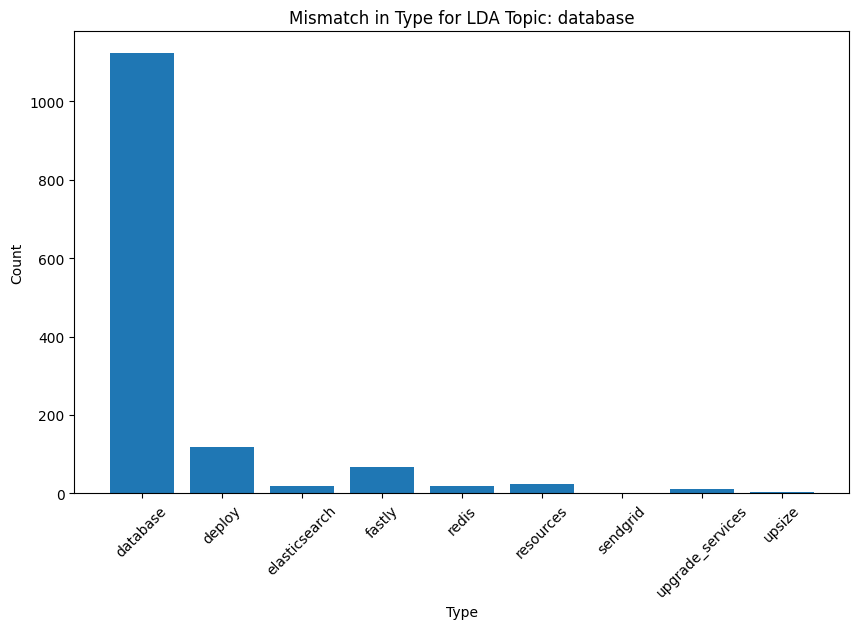

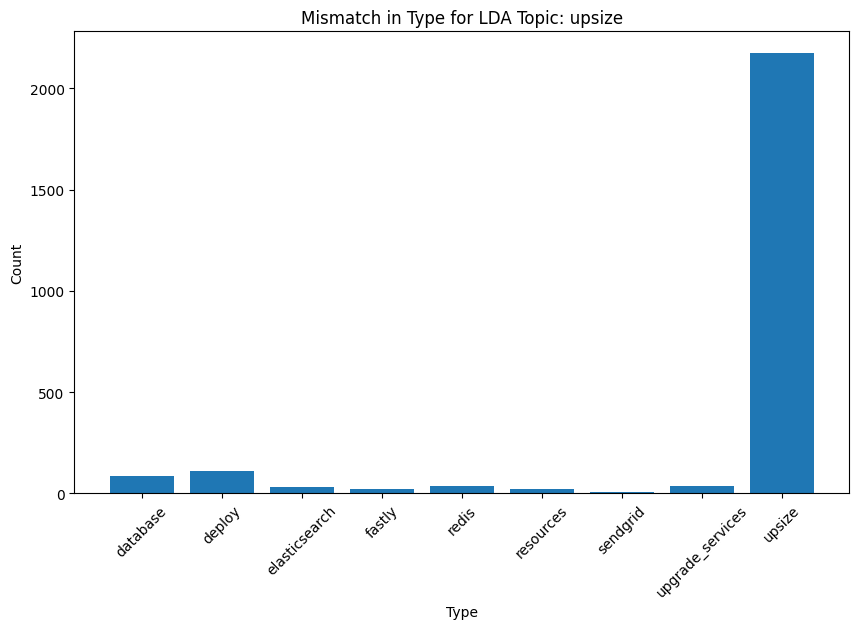

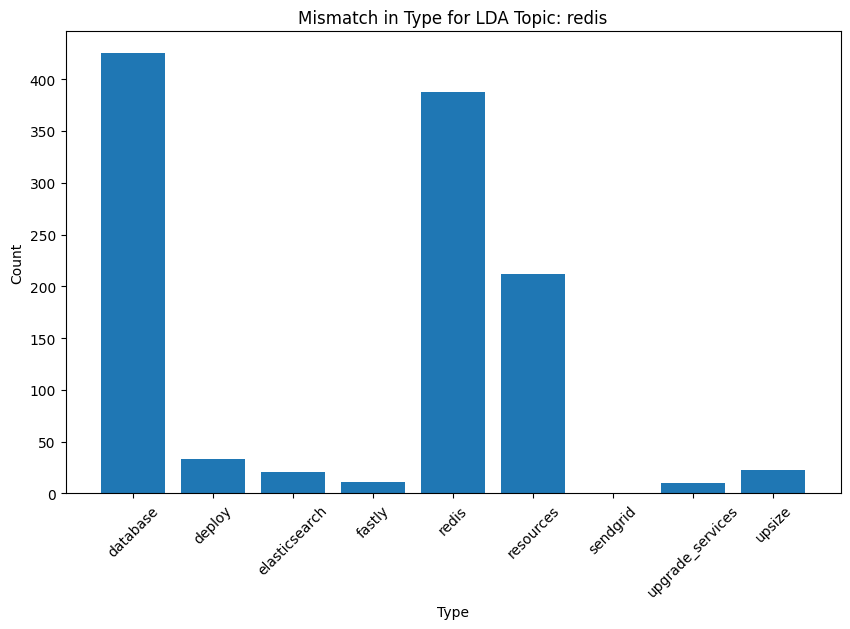

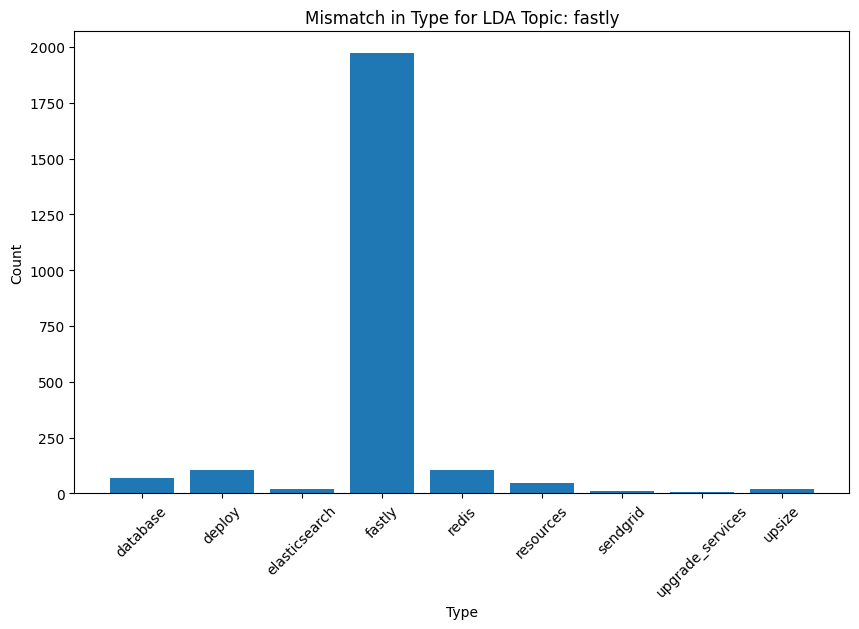

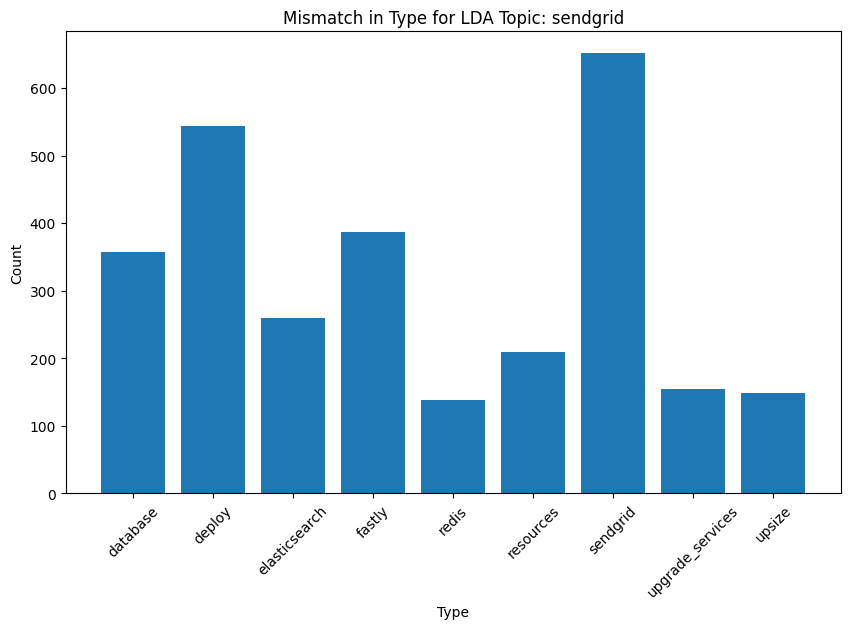

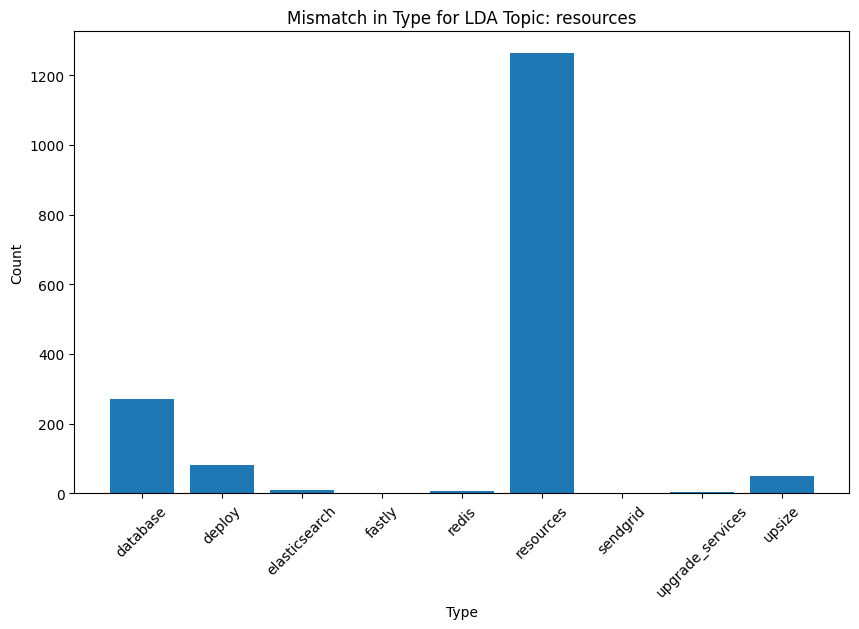

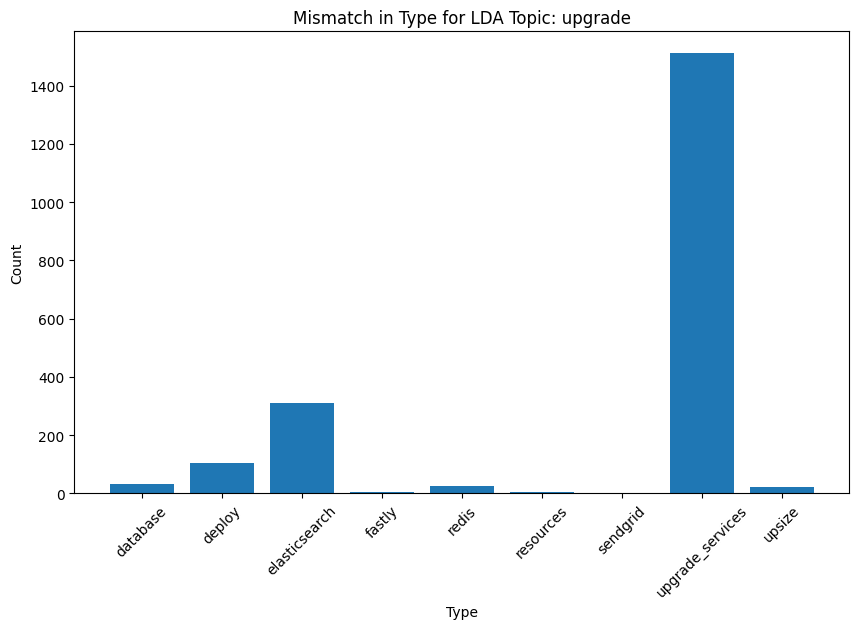

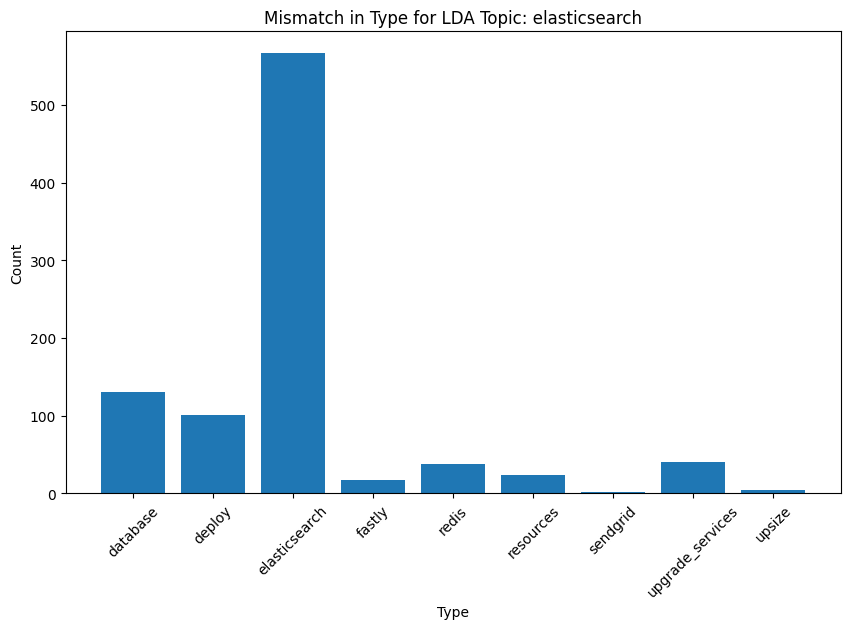

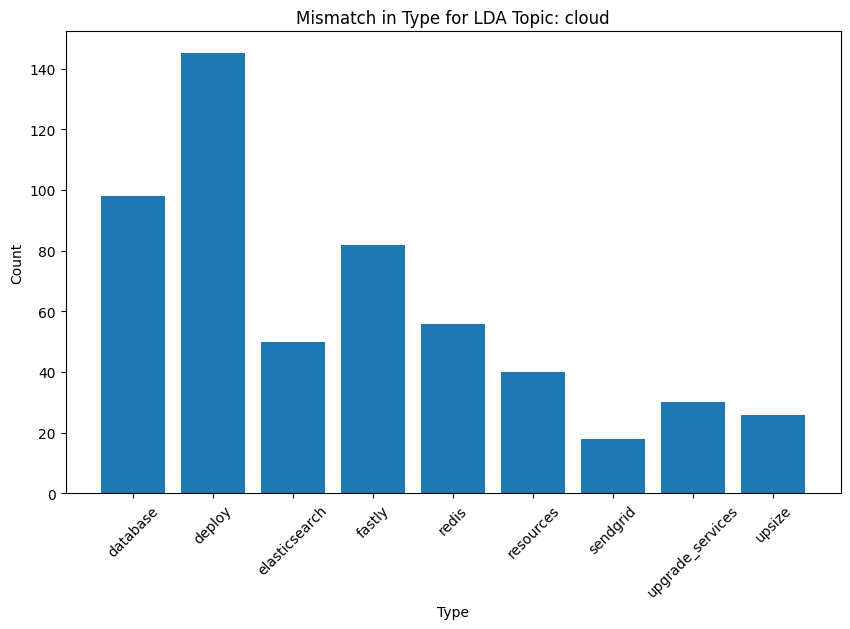

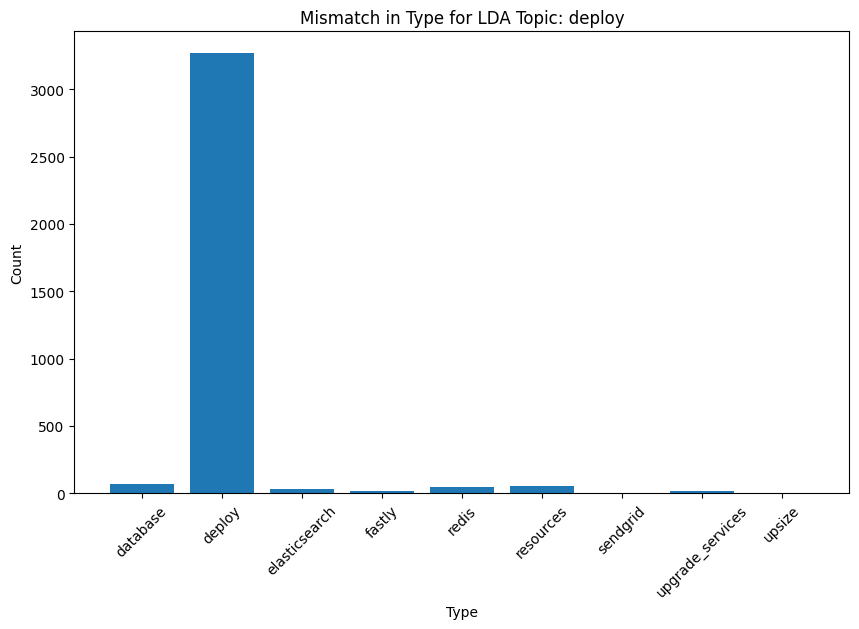

In [ ]:
# Group the data by 'topic' and 'type' and count the occurrences
topic_type_counts = filtered_df.groupby(['lda_topic', 'type']).size().reset_index(name='count')

# Create a bar chart for each topic
for topic in filtered_df['lda_topic'].unique():
  # Filter the data for the current topic
  topic_data = topic_type_counts[topic_type_counts['lda_topic'] == topic]
  plt.figure(figsize=(10,6))
  # Create a bar chart
  plt.bar(topic_data['type'], topic_data['count'])
  plt.xticks(rotation=45)
  # Set the x-axis label
  plt.xlabel('Type')

  # Set the y-axis label
  plt.ylabel('Count')

  # Set the title of the chart
  plt.title(f'Mismatch in Type for LDA Topic: {topic}')

  # Display the chart
  plt.show()


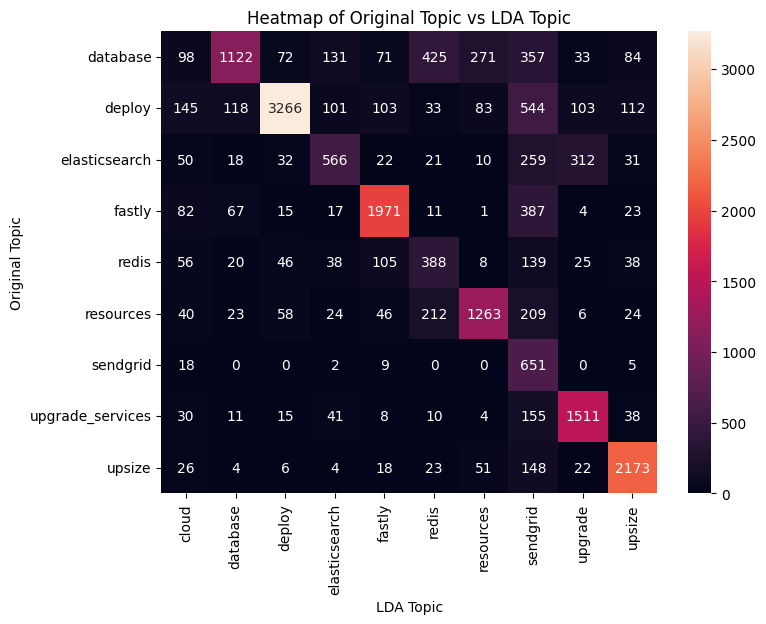

In [ ]:
# converting to categorical variables
filtered_df['type'] = pd.Categorical(filtered_df['type'])
filtered_df['lda_topic'] = pd.Categorical(filtered_df['lda_topic'])

# Create a cross-tabulation of the two variables
cross_tab = pd.crosstab(filtered_df['type'], filtered_df['lda_topic'])
sns.color_palette("cubehelix", as_cmap=True)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cross_tab, annot=True, fmt='d')
plt.title('Heatmap of Original Topic vs LDA Topic')
plt.xlabel('LDA Topic')
plt.ylabel('Original Topic')
plt.show()

In [ ]:
# Loading into a csv file
filtered_df.to_csv('lda_categories_apr23.csv')

In [ ]:
df_lda = pd.read_csv('lda_categories_apr23.csv')

In [ ]:
df_lda = df_lda.rename(columns={'type':'og'})

In [ ]:
# Rename categories
df_lda['lda_topic'] = df_lda['lda_topic'].str.lower()
df_lda['lda_topic'] = df_lda['lda_topic'].replace('upgrade', 'upgrade_services')
df_lda['lda_topic'] = df_lda['lda_topic'].replace('deployment_issues', 'deploy')
df_lda['lda_topic'] = df_lda['lda_topic'].replace('application_deployment_issues', 'app_deploy')
df_lda['lda_topic'] = df_lda['lda_topic'].replace('memory', 'redis')
# Recheck categories
print('LDA')
print(pd.unique(df_lda['lda_topic']))
print('OG')
print(pd.unique(df_lda['og']))

LDA
['database' 'upsize' 'redis' 'fastly' 'sendgrid' 'resources'
 'upgrade_services' 'elasticsearch' 'cloud' 'deploy']
OG
['database' 'upgrade_services' 'elasticsearch' 'sendgrid' 'redis' 'fastly'
 'resources' 'upsize' 'deploy']


In [ ]:
# Assign independent and dependent variables
x = df_lda['tfidf_text']
y = df_lda[['og','lda_topic']]

# Split datasets into training and testing sets
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2, random_state = 0)

# Define vectorizer
vectorizer = TfidfVectorizer()

# Vectorize xtrain and xtest
vector_xtrain = vectorizer.fit_transform(xtrain)
vector_xtest = vectorizer.transform(xtest)

In [ ]:
# Produce a classification report
print(classification_report(y['og'], y['lda_topic']))

/Users/anishachitturu/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                  precision    recall  f1-score   support

           cloud       0.00      0.00      0.00         0
        database       0.81      0.42      0.55      2664
          deploy       0.93      0.71      0.80      4608
   elasticsearch       0.61      0.43      0.50      1321
          fastly       0.84      0.76      0.80      2578
           redis       0.35      0.45      0.39       863
       resources       0.75      0.66      0.70      1905
        sendgrid       0.23      0.95      0.37       685
upgrade_services       0.75      0.83      0.79      1823
          upsize       0.86      0.88      0.87      2475

        accuracy                           0.68     18922
       macro avg       0.61      0.61      0.58     18922
    weighted avg       0.78      0.68      0.71     18922



/Users/anishachitturu/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anishachitturu/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
filtered_df['lda_topic'].value_counts()

lda_topic
deploy           3510
sendgrid         2849
upsize           2528
fastly           2353
upgrade          2016
resources        1691
database         1383
redis            1123
elasticsearch     924
cloud             545
Name: count, dtype: int64